# Exploratory Data Analysis (EDA) of Colorectal Cancer Bulk RNA-seq Atlas

## Introduction

This notebook performs an initial exploration of a colorectal cancer (CRC) bulk RNA-seq dataset that has been batch-corrected using `pycombat-seq`. 

The goals are to:
- Summarize the clinical and molecular cohort composition.
- Visualize distributions of key variables.
- Perform dimensionality reduction (PCA, UMAP) to reveal biological patterns or clusters.
- Generate hypotheses for downstream analyses based on observed data structure.

## Dataset

- **Gene expression matrix**: normalized and batch-corrected bulk RNA-seq data.
- **Clinical metadata**: patient and sample information including biopsy site, sample type, and clinical variables.

## Sample Sources

The samples used in this analysis are derived from three primary public resources:

- **GEO (Gene Expression Omnibus):** Individual experimental samples identified by GSM accessions.
- **GTEx (Genotype-Tissue Expression Project):** Healthy human tissue samples with IDs starting with "GTEX-".
- **TCGA (The Cancer Genome Atlas):** Cancer patient tumor and normal samples following the TCGA barcode format.

These diverse datasets provide a comprehensive overview of gene expression across healthy and diseased states.

## Tools & Libraries

We use Python libraries such as `pandas`, `matplotlib`, `seaborn`, and `plotly` for data processing and visualization.




## 1. Cohort Overview & Data Integrity

In this section, we perform an initial summary of the colorectal cancer (CRC) cohort and assess the integrity of the data. This includes:

- Summarizing the number of samples and patients
- Characterizing clinical variables such as biopsy site, sample type, age, and stage
- Checking for missing values and data completeness
- Verifying data types and value distributions

Understanding the structure and quality of the data is critical before proceeding to downstream analyses.


In [1]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import umap
import scanpy as sc
import anndata

# load the data
metadata_df = pd.read_csv('../data/CRC_atlas_clinical_data.csv', index_col=0)
expression_df = pd.read_csv('../data/CRC_atlas_gene_expression_data.csv', index_col=0)

/home/fatouh/anaconda3/envs/crc_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Display basic info
print("Clinical Data Overview:")
metadata_df.columns = metadata_df.columns.str.replace(' ', '_').str.lower()
display(metadata_df.shape)
display(metadata_df.info())
display(metadata_df.head())

Clinical Data Overview:


(2770, 34)

<class 'pandas.core.frame.DataFrame'>
Index: 2770 entries, GSM1133352 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1776 non-null   float64
 1   age_category          1442 non-null   object 
 2   biopsy_subsite        1296 non-null   object 
 3   braf_mutation         619 non-null    object 
 4   biopsy_site           2770 non-null   object 
 5   biopsy_timepoint      1425 non-null   object 
 6   cms                   581 non-null    object 
 7   cancer_type           631 non-null    object 
 8   distal_vs_proximal    1662 non-null   object 
 9   donor_type            2770 non-null   object 
 10  egfr_mutated          515 non-null    object 
 11  grade                 79 non-null     object 
 12  her2_mutation         0 non-null      float64
 13  histological_subtype  1966 non-null   object 
 14  histological_type     1966 non-null   object

None

,age,age_category,biopsy_subsite,braf_mutation,biopsy_site,biopsy_timepoint,cms,cancer_type,distal_vs_proximal,donor_type,...,pfs_time,sample_type,gender,stage,tmb,tmb_group,tp53_mutation,therapy_response,therapy_type,tumor_type
GSM1133352,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133353,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133355,76.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042099,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042100,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor


In [3]:
# Count unique values per column
unique_counts = metadata_df.nunique()

# Identify columns with only one unique value
cols_to_drop = unique_counts[unique_counts <= 1].index.tolist()

print("Dropped columns with a single unique value:")
for col in cols_to_drop:
    print(f"- {col}")

# Drop those columns
metadata_df = metadata_df.loc[:, unique_counts > 1]

print(f"Dropped {len(cols_to_drop)} columns in total.")


Dropped columns with a single unique value:
- age_category
- cancer_type
- her2_mutation
- line_of_treatment
- tumor_type
Dropped 5 columns in total.


In [4]:
# Condition 1: donor_type == 'Tumor' → sample_type == 'Primary cancer'
cond1 = (metadata_df['donor_type'] == 'Tumor') & (metadata_df['sample_type'] != 'Primary cancer')
num_violations1 = cond1.sum()

print(f"Number of samples where donor_type is 'Tumor' but sample_type is NOT 'Primary cancer': {num_violations1}")


# Condition 2: donor_type == 'Normal' → sample_type == 'Healthy sample'
cond2 = (metadata_df['donor_type'] == 'Normal') & (metadata_df['sample_type'] != 'Healthy sample')
num_violations2 = cond2.sum()

print(f"\nNumber of samples where donor_type is 'Normal' but sample_type is NOT 'Healthy sample': {num_violations2}")

metadata_df= metadata_df.loc[~ cond1]
expression_df = expression_df.loc[:, ~cond1]

metadata_df = metadata_df.drop(['donor_type'], axis=1)

Number of samples where donor_type is 'Tumor' but sample_type is NOT 'Primary cancer': 2

Number of samples where donor_type is 'Normal' but sample_type is NOT 'Healthy sample': 0


In [ ]:
cancer_df = metadata_df[metadata_df["sample_type"] == "Primary cancer"]
total_samples = cancer_df.shape[0]

# Step 2: Find features with >20% missing data in cancer samples
missing_fraction = cancer_df.isnull().mean()
sparse_features = missing_fraction[missing_fraction > 0.10].index

print(f"\nFeatures with >20% missing in Primary_cancer samples ({len(sparse_features)} features):\n")
print(sparse_features.tolist())

# Step 3: Plot distributions for sparse features
for col in sparse_features:
    print(f"\n📊 Distribution of values for '{col}' ({cancer_df[col].notnull().sum()} non-null entries):")

    # Categorical (object or low-unique numeric)
    if cancer_df[col].dtype == 'object' or cancer_df[col].nunique() < 10:
        value_counts = cancer_df[col].value_counts(dropna=True)
        print(value_counts)

        # Bar plot
        value_counts.plot(kind='bar', title=f"{col} value counts", figsize=(6, 4))
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    # Numerical
    else:
        desc = cancer_df[col].describe()
        print(desc)

        # Histogram
        sns.histplot(cancer_df[col].dropna(), bins=20, kde=True)
        plt.title(f"{col} distribution")
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

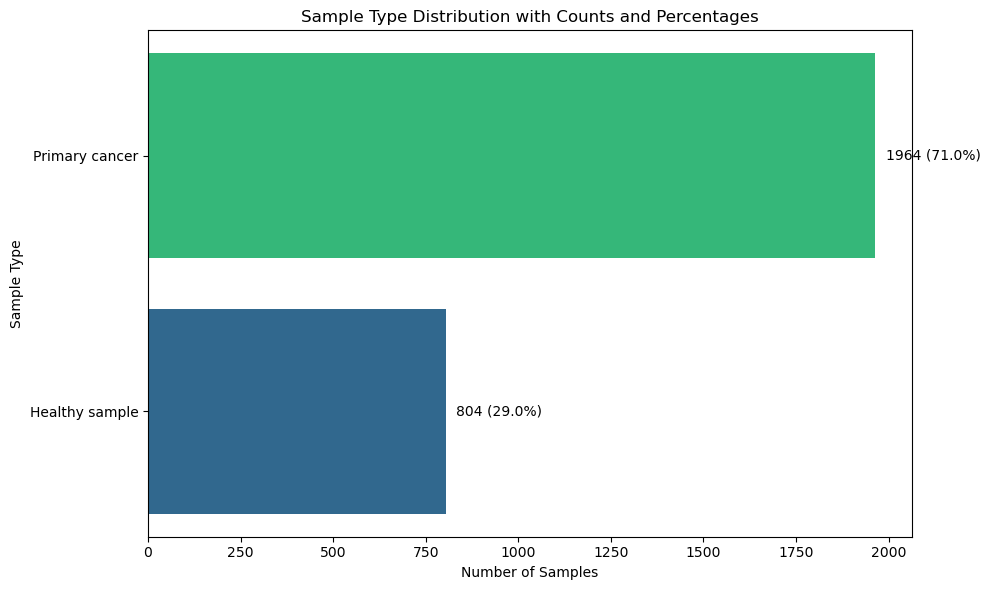

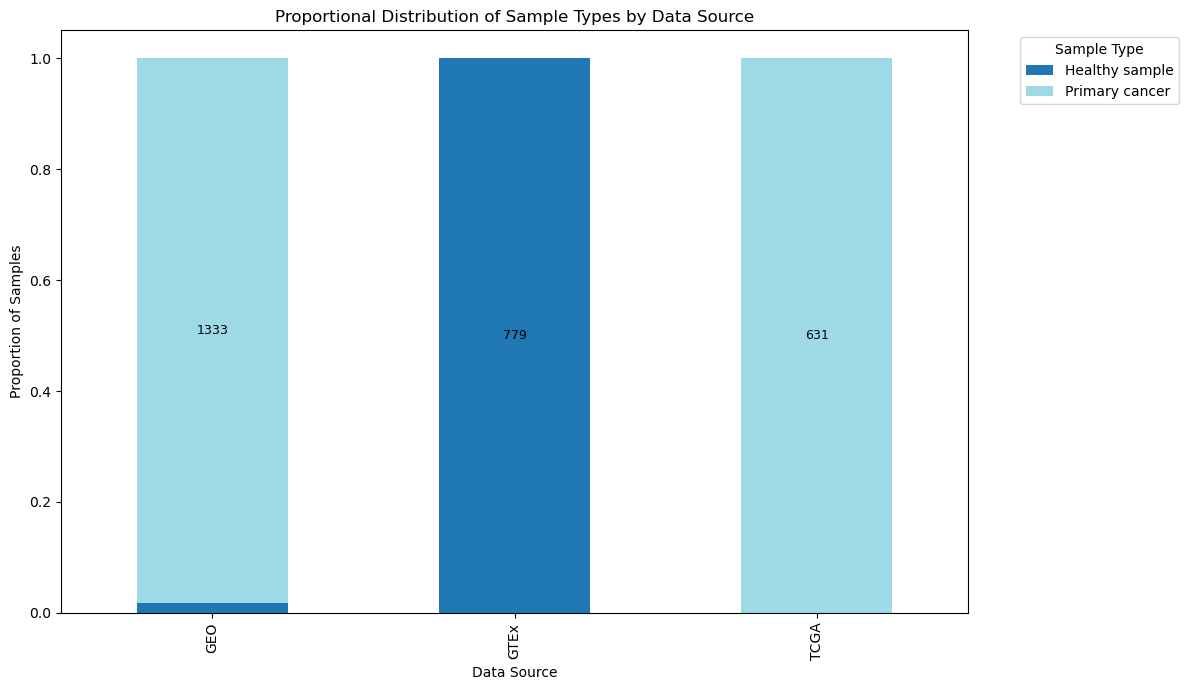

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create data_source column
def get_data_source(sample_id):
    if sample_id.startswith('GSM'):
        return 'GEO'
    elif sample_id.startswith('GTEX'):
        return 'GTEx'
    elif sample_id.startswith('TCGA'):
        return 'TCGA'


metadata_df['data_source'] = metadata_df.index.map(get_data_source)

# 1) Horizontal bar plot with percentages for sample_type
sample_type_counts = metadata_df['sample_type'].value_counts().sort_values()
total_samples = len(metadata_df)

plt.figure(figsize=(10, 6))
bars = plt.barh(sample_type_counts.index, sample_type_counts.values, color=sns.color_palette("viridis", len(sample_type_counts)))

# Annotate percentages
for bar in bars:
    width = bar.get_width()
    plt.text(width + total_samples*0.01, bar.get_y() + bar.get_height()/2,
             f'{width} ({width/total_samples:.1%})',
             va='center', fontsize=10)

plt.title('Sample Type Distribution with Counts and Percentages')
plt.xlabel('Number of Samples')
plt.ylabel('Sample Type')
plt.tight_layout()
plt.show()

# 2) Stacked bar plot of sample_type by data_source
ct = pd.crosstab(metadata_df['data_source'], metadata_df['sample_type'], normalize='index')  # proportions by data_source

ct_counts = pd.crosstab(metadata_df['data_source'], metadata_df['sample_type'])  # counts

ct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12,7))
plt.title('Proportional Distribution of Sample Types by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Proportion of Samples')

# Annotate counts on bars
for i, data_source in enumerate(ct.index):
    cum_width = 0
    for sample_type in ct.columns:
        val = ct.loc[data_source, sample_type]
        count = ct_counts.loc[data_source, sample_type]
        if val > 0.05:  # annotate only if >5%
            plt.text(i, cum_width + val/2, f'{count}', ha='center', va='center', fontsize=9, color='black')
        cum_width += val

plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


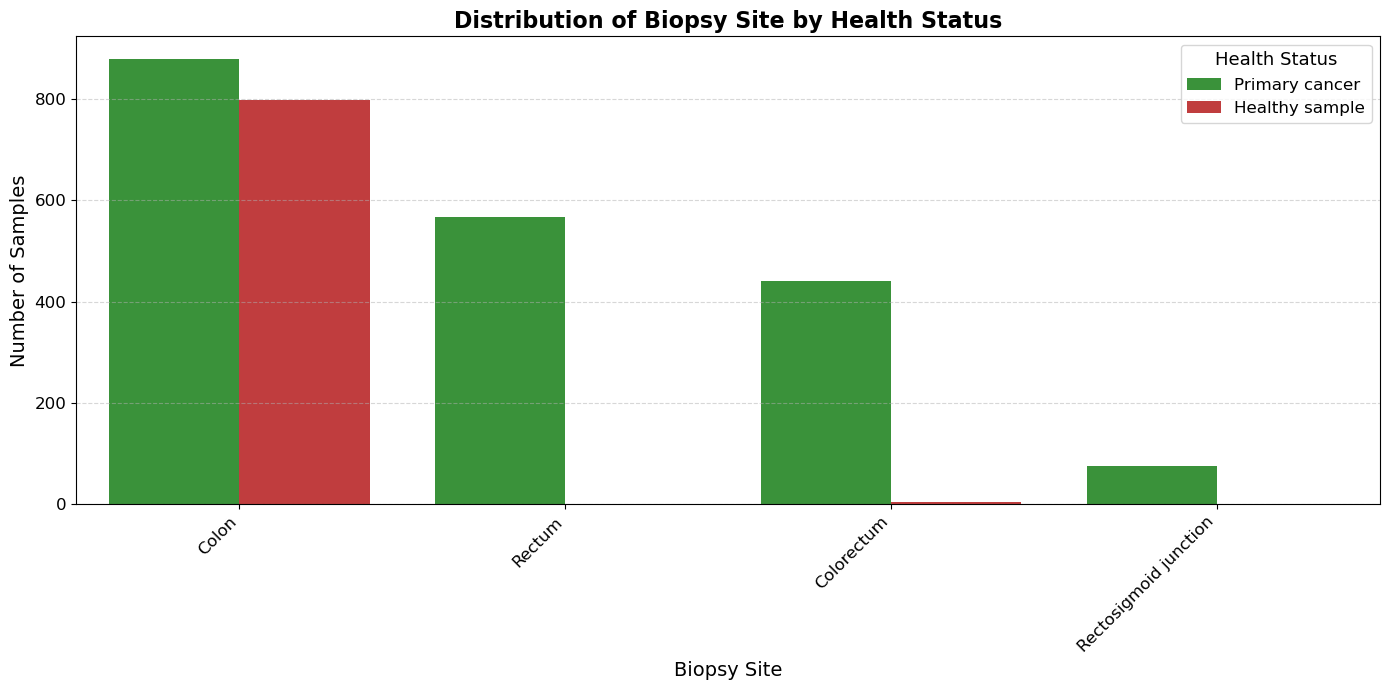

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 7))
sns.countplot(data=metadata_df, x='biopsy_site', hue='sample_type', palette=['#2ca02c', '#d62728'])

plt.title('Distribution of Biopsy Site by Health Status', fontsize=16, weight='bold')
plt.xlabel('Biopsy Site', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Health Status', title_fontsize='13', fontsize='12')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


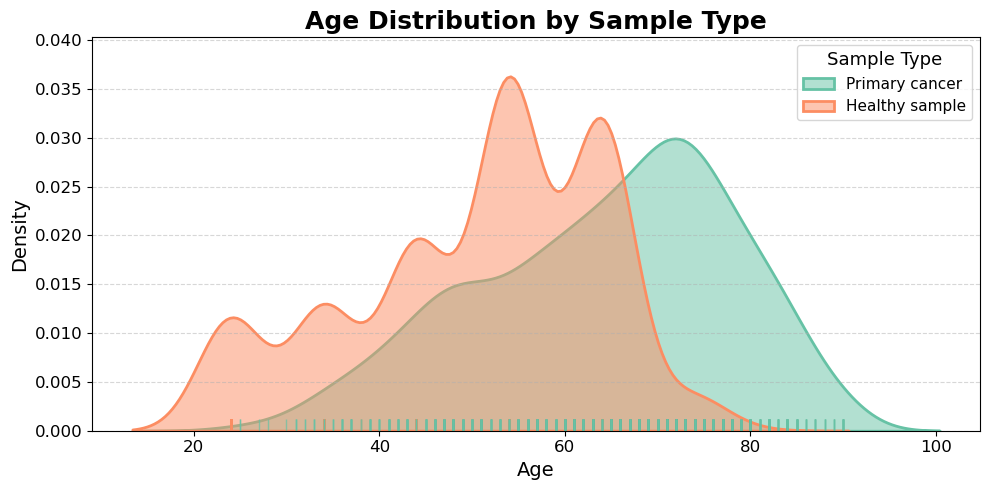

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out missing age or sample_type
age_sample = metadata_df[['age', 'sample_type']].dropna()

plt.figure(figsize=(10, 5))

# Define colors with more contrast and saturation
palette = sns.color_palette('Set2', len(age_sample['sample_type'].unique()))

# Plot KDE with filled areas and a slight transparency
for i, stype in enumerate(age_sample['sample_type'].unique()):
    subset = age_sample[age_sample['sample_type'] == stype]['age']
    sns.kdeplot(subset, fill=True, alpha=0.5, linewidth=2, label=stype, color=palette[i])

# Add rug plot for individual data points
sns.rugplot(data=age_sample, x='age', hue='sample_type', palette=palette, height=0.03, alpha=0.7)

# Style enhancements
plt.title('Age Distribution by Sample Type', fontsize=18, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Sample Type', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [9]:
num_under_18 = (metadata_df['age'] < 18).sum()
total_samples = len(metadata_df)
print(f"Samples with Age < 18: {num_under_18} / {total_samples} ({num_under_18/total_samples:.1%})")

# Check how many missing in Age category
num_missing = metadata_df['age'].isna().sum()
total = len(metadata_df)
print(f"Missing values in 'Age': {num_missing} / {total} ({num_missing/total:.1%})")

Samples with Age < 18: 0 / 2768 (0.0%)
Missing values in 'Age': 994 / 2768 (35.9%)


In [10]:
scaler = StandardScaler()
def scale_age_groupwise(df):
    # Make a copy to avoid modifying original
    df = df.copy()
    df['age_scaled'] = scaler.fit_transform(df[['age']])
    return df

# Apply scaling group-wise, keep index with groupby + apply
scaled_df = metadata_df.groupby('sample_type').apply(scale_age_groupwise)

# scaled_df now has a multiindex with group as one level, so reset index only for group, keep original index:
scaled_df = scaled_df.reset_index(level=0, drop=True)

# Optionally assign back to original df (if you want to keep in same variable)
metadata_df['age'] = scaled_df['age_scaled']

/tmp/ipykernel_3083080/1911849835.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_df = metadata_df.groupby('sample_type').apply(scale_age_groupwise)


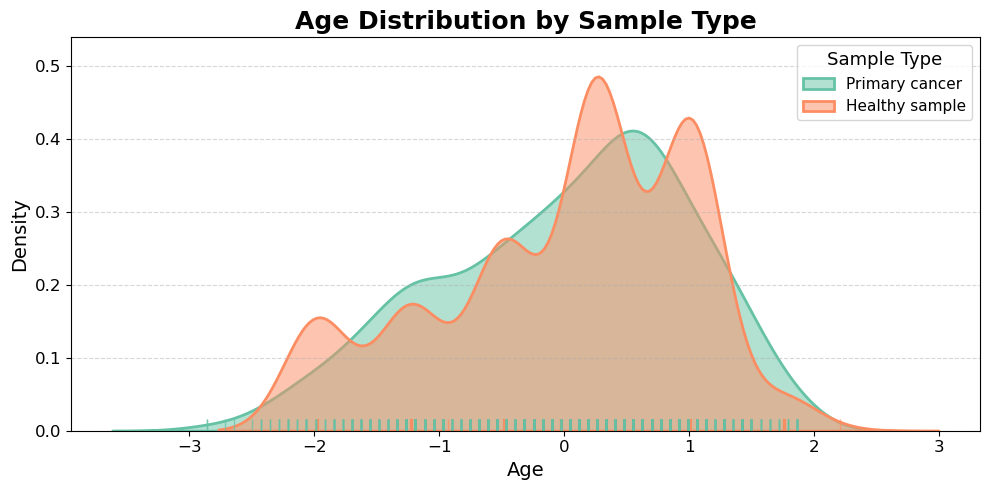

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out missing age or sample_type
age_sample = metadata_df[['age', 'sample_type']].dropna()

plt.figure(figsize=(10, 5))

# Define colors with more contrast and saturation
palette = sns.color_palette('Set2', len(age_sample['sample_type'].unique()))

# Plot KDE with filled areas and a slight transparency
for i, stype in enumerate(age_sample['sample_type'].unique()):
    subset = age_sample[age_sample['sample_type'] == stype]['age']
    sns.kdeplot(subset, fill=True, alpha=0.5, linewidth=2, label=stype, color=palette[i])

# Add rug plot for individual data points
sns.rugplot(data=age_sample, x='age', hue='sample_type', palette=palette, height=0.03, alpha=0.7)

# Style enhancements
plt.title('Age Distribution by Sample Type', fontsize=18, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Sample Type', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



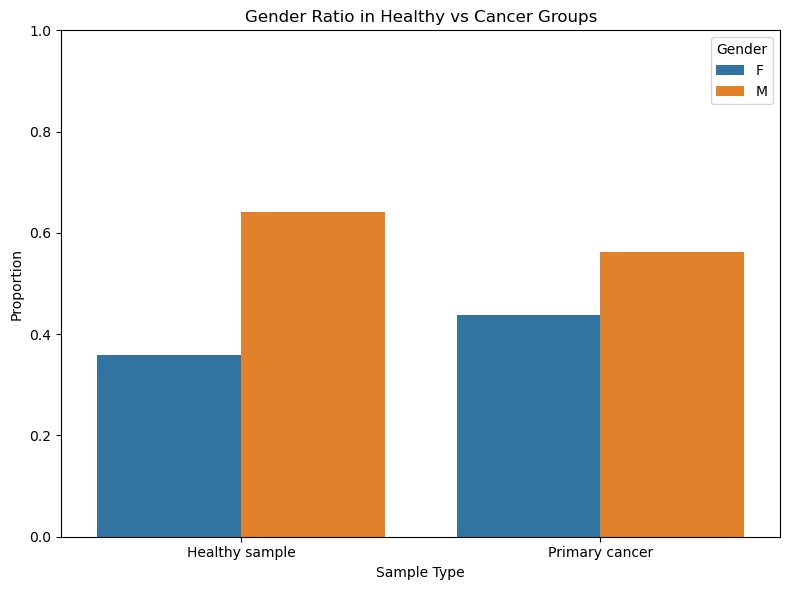

In [12]:
df_plot = metadata_df[metadata_df['sample_type'].isin(['Healthy sample', 'Primary cancer'])]

# Calculate counts
counts = df_plot.groupby(['sample_type', 'gender']).size().reset_index(name='count')

# Calculate total counts per sample_type for ratio
totals = counts.groupby('sample_type')['count'].transform('sum')
counts['ratio'] = counts['count'] / totals

# Plot with ratios
plt.figure(figsize=(8,6))
sns.barplot(data=counts, x='sample_type', y='ratio', hue='gender')

plt.title('Gender Ratio in Healthy vs Cancer Groups')
plt.ylabel('Proportion')
plt.xlabel('Sample Type')
plt.ylim(0, 1)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [13]:
print("\nExpression Data Overview:")
display(expression_df.shape)
display(expression_df.head())



Expression Data Overview:


(22723, 2768)

,GSM1133353,GSM2042099,GSM2042100,GSM2042101,GSM2042102,GSM2042124,GSM2042125,GSM2042126,GSM2042127,GSM2042128,...,TCGA-F5-6811-01A-11R-1830-07,TCGA-F5-6814-01A-31R-1928-07,TCGA-F5-6861-01A-11R-1928-07,TCGA-F5-6863-01A-11R-1928-07,TCGA-F5-6864-01A-11R-1928-07,TCGA-G5-6233-01A-11R-1736-07,TCGA-G5-6235-01A-11R-1736-07,TCGA-G5-6572-01A-11R-1830-07,TCGA-G5-6572-02A-12R-1830-07,TCGA-G5-6641-01A-11R-A32Z-07
A1BG,7.0,9.0,46.0,105.0,21.0,18.0,32.0,18.0,30.0,20.0,...,1.0,6.0,1.0,0.0,6.0,1.0,2.0,1.0,54.0,1.0
A1BG-AS1,3.0,17.0,44.0,95.0,28.0,16.0,27.0,21.0,26.0,19.0,...,9.0,11.0,3.0,13.0,27.0,9.0,2.0,7.0,10.0,1.0
A1CF,2.0,272.0,241.0,540.0,522.0,1384.0,2037.0,1468.0,1211.0,1208.0,...,1293.0,643.0,1561.0,894.0,1107.0,919.0,2665.0,2952.0,7298.0,1803.0
A2M,261.0,1229.0,6595.0,16567.0,3268.0,6031.0,7256.0,8621.0,5744.0,3951.0,...,26514.0,22071.0,13703.0,22004.0,53366.0,17415.0,3269.0,22187.0,143106.0,5077.0
A2M-AS1,3.0,41.0,192.0,369.0,83.0,64.0,104.0,114.0,114.0,119.0,...,61.0,18.0,19.0,27.0,53.0,17.0,6.0,46.0,48.0,4.0


#### 🔬 Normalization of Batch-Corrected Bulk RNA-seq Data

After batch correction using **ComBat-Seq**, I applied the following normalization steps:

1. **TMM Normalization**  
   - Performed using **CoNorm**, which implements the **Trimmed Mean of M-values (TMM)** method.
   - This corrects for differences in library size and composition between samples.

2. **Log Transformation**  
   - Applied log2 transformation with a pseudocount
   - Reduces skewness and stabilizes variance across genes.

3. **Z-score Scaling**  
   - Standardized each gene (row-wise) to mean 0 and standard deviation 1
   - Useful for clustering, PCA, and other machine learning tasks.



In [14]:
# TMM normalization
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)

# Keep genes expressed in at least 20% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:]

# z-score calculation
scaler = StandardScaler()
scaled_log_tmm = pd.DataFrame(scaler.fit_transform(filtered_expr.T),
                              index=filtered_expr.columns,
                              columns=filtered_expr.index)
# examining final normalized file
scaled_log_tmm.shape

(2768, 19832)

/home/fatouh/anaconda3/envs/crc_env/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


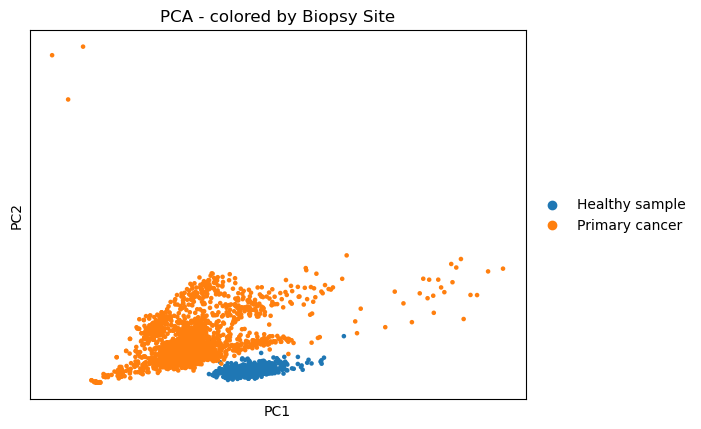

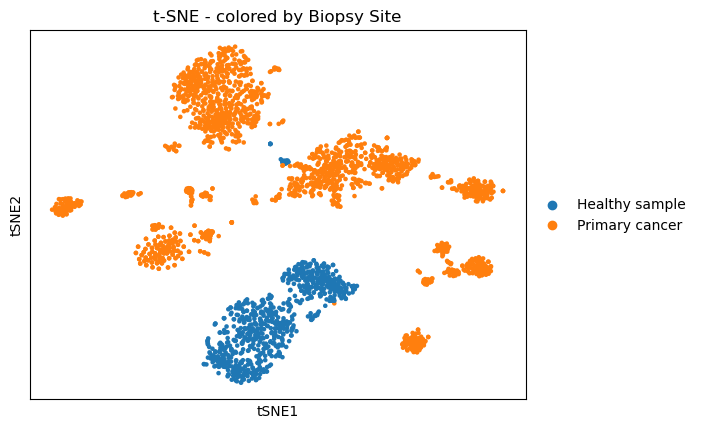

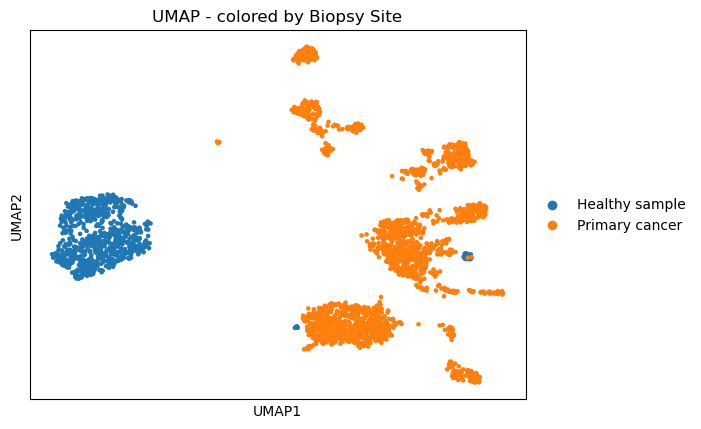

In [15]:
filtered_expr = filtered_expr.transpose()
adata = anndata.AnnData(filtered_expr)

# chack the match in index
metadata_df = metadata_df.loc[adata.obs_names]

# Add all columns from metadata_df to adata.obs
for col in metadata_df.columns:
    adata.obs[col] = metadata_df[col]

# Select Highly Variable Genes 
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)
adata = adata[:, adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata)

# t-SNE
sc.tl.tsne(adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# Plot PCA colored by sample_type
sc.pl.pca(adata, color='sample_type', title='PCA - colored by Biopsy Site')

# Plot t-SNE colored by sample_type
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by Biopsy Site')

# Plot UMAP colored by sample_type
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by Biopsy Site')

In [17]:
# Expression matrix as DataFrame (samples x genes)
expr_df = pd.DataFrame(
    adata.X, 
    index=adata.obs_names, 
    columns=adata.var_names
)

## saving the files
expr_df.to_csv('../data/processed_expression.csv')


fig, ax = plt.subplots()
sc.pl.pca(adata, color='sample_type', title='PCA - colored by sample type', ax=ax, show=False)
fig.savefig('../results/pca_sample_type.png')
plt.close(fig)

fig, ax = plt.subplots()
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by sample type', ax=ax, show=False)
fig.savefig('../results/tsne_sample_type.png')
plt.close(fig)

fig, ax = plt.subplots()
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by sample type', ax=ax, show=False)
fig.savefig('../results/umap_sample_type.png')
plt.close(fig)
